## Spectrogram Visualizer
The following notebook enables one to visualize the spectrogram he/she will get during trainig. This code aims to mimic the "getitem" functionalities, and show the spectrogram the model gets

In [1]:
import sys
from pathlib import Path
import yaml
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from pprint import pprint
import torch
import librosa.display


sys.path.append('..')

In [2]:
from soundbay.data import ClassifierDataset

In [3]:
## utils

class DotDictWrapper:
    """
    d['key']==d.key
    """
    def __init__(self, d):
        self._dict = d

    def __getattr__(self, name):
        if name in self._dict:
            return self._dict[name]
        else:
            raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

    def __getitem__(self, key):
        return self._dict[key]

### Your params here

In [4]:
# load augmentation and preprocessors - you can choose what yaml file to load by changing the path below
with open('../soundbay/conf/preprocessors/_preprocessors.yaml', 'r') as file:
    preprocessors = yaml.safe_load(file)
with open('../soundbay/conf/augmentations/_augmentations.yaml', 'r') as file:
    augmentations = yaml.safe_load(file)
with open('../soundbay/conf/data/defaults.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
data = data['data']
preprocessors=preprocessors['_preprocessors']
augmentations = augmentations['_augmentations']

In [5]:
pprint(data)

{'batch_size': 64,
 'data_sample_rate': 44100,
 'hop_length': 256,
 'label_names': ['Noise', 'Call'],
 'max_freq': 8000,
 'min_freq_filtering': 0,
 'n_fft': 1024,
 'num_workers': 10,
 'sample_rate': 16000,
 'train_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                   'augmentations': '${_augmentations}',
                   'augmentations_p': 0.8,
                   'data_path': './tests/assets/data/',
                   'data_sample_rate': '${data.data_sample_rate}',
                   'margin_ratio': 0.5,
                   'metadata_path': './tests/assets/annotations/sample_annotations.csv',
                   'mode': 'train',
                   'preprocessors': '${_preprocessors}',
                   'sample_rate': '${data.sample_rate}',
                   'seq_length': 1,
                   'slice_flag': False},
 'val_dataset': {'_target_': 'soundbay.data.ClassifierDataset',
                 'augmentations': None,
                 'augmentations_p': 0,
      

In [6]:
## you can tune the parameters from here, or you can change them in the yaml files and then load again
print(f"before: {data['data_sample_rate']}")
data['data_sample_rate'] = 96000
print(f"after: {data['data_sample_rate']}")

before: 44100
after: 96000


In [7]:
aggr_conf = OmegaConf.create({'data':data, 'preprocessors':preprocessors, 'augmentations':augmentations})

In [8]:
cfg = DotDictWrapper({
    'data_path': '/mnt/shai2/soundbay/amber',
    'metadata_path': '/home/shai/personal/soundbay/amber_aus/data/val_calls_det.csv',
    'augmentations': aggr_conf.augmentations,
    'augmentations_p': aggr_conf.data.train_dataset.augmentations_p,
    'preprocessors': aggr_conf.preprocessors,
    'seq_length': aggr_conf.data.train_dataset.seq_length,
    'data_sample_rate': aggr_conf.data.data_sample_rate,
    'sample_rate': aggr_conf.data.sample_rate,
    'mode': "train",
    'slice_flag': False,
    'margin_ratio': 0,
    'split_metadata_by_label': False,
})

# cfg_val = ... 

# initiate the dataset

dataset_train = ClassifierDataset(cfg.data_path, cfg.metadata_path, cfg.augmentations, cfg.augmentations_p, cfg.preprocessors,
                 cfg.seq_length, cfg.data_sample_rate, cfg.sample_rate, cfg.mode,
                 cfg.slice_flag, cfg.margin_ratio, cfg.split_metadata_by_label)

In [9]:
dataset_train.metadata.head()

,begin_time,end_time,filename,call_length,label,channel
0,4.884327,6.657663,PPB04082019_ZOOM0221,1.773336,1,1
1,1.977723,7.131551,PPB04082019_ZOOM0223,5.153828,1,1
2,87.351860,87.767037,PPB04082019_ZOOM0223,0.415177,1,1
3,72.701655,74.017855,PPB04082019_ZOOM0224,1.316200,1,1
4,74.070699,74.830384,PPB04082019_ZOOM0224,0.759686,1,1


___
---

### Functionalities from getitem

In [10]:
"""
__getitem__ method loads item according to idx from the metadata
path_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)
audio = self._get_audio(path_to_file, begin_time, end_time, label, channel)
audio_raw = self.sampler(audio)
audio_augmented = self.augment(audio_raw)
audio_processed = self.preprocessor(audio_augmented)
"""

'\n__getitem__ method loads item according to idx from the metadata\npath_to_file, begin_time, end_time, label, channel = self._grab_fields(idx)\naudio = self._get_audio(path_to_file, begin_time, end_time, label, channel)\naudio_raw = self.sampler(audio)\naudio_augmented = self.augment(audio_raw)\naudio_processed = self.preprocessor(audio_augmented)\n'

In [11]:
def show_spectrogram(audio_processed, title, label):
    plt.figure()
    librosa.display.specshow(audio_processed)
    plt.title(f"{str(title)} label: {label}")
    plt.show()

In [12]:
indices_to_check = [1,10,20]

audio.shape: torch.Size([1, 96000])
audio_raw.shape: torch.Size([1, 16000])
audio_augmented.shape: torch.Size([1, 16000])
audio_processed.shape: torch.Size([1, 513, 63])


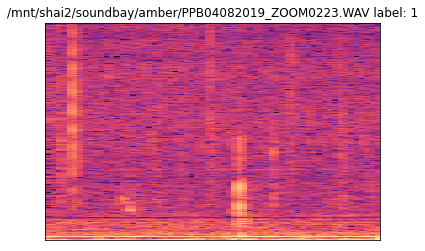

audio.shape: torch.Size([1, 96000])
audio_raw.shape: torch.Size([1, 16000])
audio_augmented.shape: torch.Size([1, 16000])
audio_processed.shape: torch.Size([1, 513, 63])


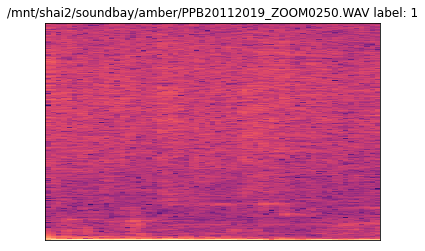

audio.shape: torch.Size([1, 96000])
audio_raw.shape: torch.Size([1, 16000])
audio_augmented.shape: torch.Size([1, 16000])
audio_processed.shape: torch.Size([1, 513, 63])


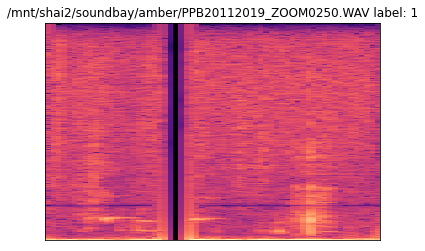

In [13]:
for idx in indices_to_check:
    path_to_file, begin_time, end_time, label, channel = dataset_train._grab_fields(idx)
    audio = dataset_train._get_audio(path_to_file, begin_time, end_time, label, channel)
    print(f"audio.shape: {audio.shape}")
    audio_raw = dataset_train.sampler(audio)
    print(f"audio_raw.shape: {audio_raw.shape}")
    audio_augmented = dataset_train.augment(audio_raw)
    print(f"audio_augmented.shape: {audio_augmented.shape}")
    audio_processed = dataset_train.preprocessor(audio_augmented)
    print(f"audio_processed.shape: {audio_processed.shape}")
    
    audio_processed = audio_processed.squeeze().cpu().numpy()
    show_spectrogram(audio_processed, title=path_to_file, label=label)